In [83]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys
sys.path.append('../../src')
sys.path.append('..')

from spaceoracle.tools.network import expand_paired_interactions
from spaceoracle.tools.network import get_human_housekeeping_genes
from spaceoracle.oracles import BaseTravLR
from spaceoracle.tools.network import encode_labels

In [108]:
import sys
sys.path.append('..')

In [109]:
adata = sc.read_h5ad('/tmp/raw_mouse_kidney_14.h5ad')

In [110]:
adata13 = sc.read_h5ad('/Users/koush/Projects/SpaceOracle/data/survey/mouse_kidney_13.h5ad')

In [111]:
adata

AnnData object with n_obs × n_vars = 6147 × 22105
    obs: 'batch', 'rxn', 'n_counts', 'ct1', 'ct2', 'ct3', 'high_q', 'ct4', 'chip', 'exp', 'cond', 'samp-id', 'samp-type'
    var: 'n_counts', 'n_cells', 'mean', 'std'
    obsm: 'spatial'
    obsp: 'connectivities', 'distances'

In [112]:
np.intersect1d(adata13.var_names, adata.var_names).__len__(), adata13.shape

(3058, (8509, 3058))

In [113]:
adata = adata[:, adata13.var_names]

In [114]:
adata.layers['raw_count'] = adata.X.copy()
adata.layers['raw_count'].max()

6495.0

In [115]:
from spaceoracle.tools.utils import scale_adata
adata = scale_adata(adata, cell_size=10)
adata

AnnData object with n_obs × n_vars = 6147 × 3058
    obs: 'batch', 'rxn', 'n_counts', 'ct1', 'ct2', 'ct3', 'high_q', 'ct4', 'chip', 'exp', 'cond', 'samp-id', 'samp-type'
    var: 'n_counts', 'n_cells', 'mean', 'std'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'raw_count'
    obsp: 'connectivities', 'distances'

In [116]:
adata.obs.ct1.value_counts()

ct1
Myeloid                4689
Lymphoid                524
Endothelial             495
Epithelial              394
Mesenchymal_Stromal      34
Erythroid                11
Name: count, dtype: int64

In [117]:
adata.obs.ct1 = adata.obs.ct1.astype(str)
adata = adata[~adata.obs.ct1.isin(["Mesenchymal_Stromal", "Erythroid"])]

In [118]:
# adata.obs = adata.obs.drop(columns=
#     ['batch', 'rxn', 
#      'n_counts', 'high_q', 'chip', 'exp', 'banksy_celltypes', 
#      'samp-id', 'samp-type', 'n_genes_by_counts', 
#      'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 
#      'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 
#      'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'])

del adata.var
del adata.uns

adata.X  = adata.layers['raw_count'].copy()

lymphoid_mask = adata.obs['ct1'] == "Lymphoid"
adata.obs.loc[lymphoid_mask, 'ct1'] = adata.obs.loc[lymphoid_mask, 'ct2']

adata.obs['cell_type'] = adata.obs['ct1'].copy()
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
adata.obs['cell_type_int'] = adata.obs['cell_type'].apply(
    lambda x: encode_labels(adata.obs['cell_type'], reverse_dict=True)[x])

adata.obs.cell_type.cat = adata.obs.cell_type.cat.remove_unused_categories()

In [119]:
adata.obs.cell_type.value_counts()

cell_type
Myeloid        4689
Endothelial     495
Epithelial      394
T               304
B               205
NK               15
Name: count, dtype: int64

In [120]:
adata.shape

(6102, 3058)

<Axes: ylabel='cell_type'>

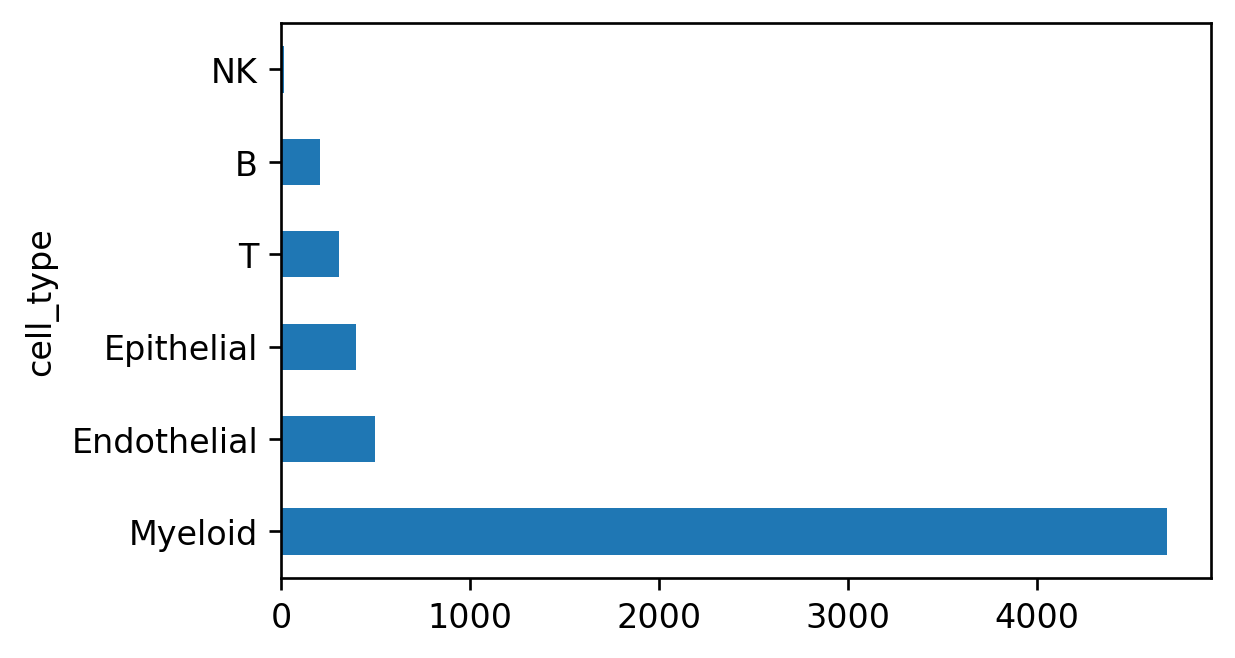

In [121]:
plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['figure.dpi'] = 120

adata.obs.cell_type.value_counts().plot(kind='barh')

In [100]:
osmogenes = ['Aqp2', 'Aqp4', 'Cryab', 'Elf5', 'Mal', 'Muc1',
        'Pax2', 'Sgk1', 'Slc14a2', 'Slc5a3']
hypoxia = ['Anxa2', 'Btg1', 'Cdkn1b', 'Ddit3', 'Hexa', 'Hoxb9', 'Hspa5', 'Tes']
markers = ['Wt1', 'Nphs2', 'Sord', 'Cyp2e1', 'Lrp2', 'Bst1', 'Slc4a11', 'Slc12a1', 
        'Umod', 'Slc12a3', 'Calb1', 'Aqp2', 'Aqp4']
nephron = ['Cldn1', 'Spp2', 'Lrp2', 'Aqp1', 'Sptssb', 'Slc12a1', 'Slc12a3', 'Calb1']
collecting_duct = ['Hsd11b2', 'Aqp4', 'Aqp2', 'Atp6v1g3', 'Gata3', 'Calb1']
vascular = ['Kdr', 'Cdh5', 'Vegfa', 'Emcn', 'Podxl']
hema = ['Cd52', 'Fcer1g']
immune = ['Thy1', 'Cd79a', 'Pax5']
stroma = ['Col1a1', 'Meis1', 'Postn']
podocyte = ['Pax8', 'Nphs1', 'Podxl', 'Meis1', 'Aldh1a2']

extra_genes = osmogenes + hypoxia + markers + \
    nephron + collecting_duct + vascular + hema + \
    immune + stroma + podocyte

In [103]:
# housekeeping_db = get_mouse_housekeeping_genes()

In [126]:
adata = adata[:, ~adata.var["mt"]]
sc.pp.log1p(adata)

In [128]:
adata.layers['normalized_count'] = adata.X.toarray().copy()

In [129]:
adata.X = adata.layers["raw_count"].copy()
adata

AnnData object with n_obs × n_vars = 6102 × 3058
    obs: 'batch', 'rxn', 'n_counts', 'ct1', 'ct2', 'ct3', 'high_q', 'ct4', 'chip', 'exp', 'cond', 'samp-id', 'samp-type', 'cell_type', 'cell_type_int', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'raw_count', 'normalized_count'
    obsp: 'connectivities', 'distances'

In [131]:
adata.layers['raw_count'].max(), adata.layers['normalized_count'].max()

(6495.0, 8.778942)

In [133]:
pcs = BaseTravLR.perform_PCA(adata)
BaseTravLR.knn_imputation(adata, pcs, method='MAGIC')

Calculating MAGIC...
  Running MAGIC on 6102 cells and 3058 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 9.49 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.83 seconds.
    Calculating affinities...
    Calculated affinities in 1.77 seconds.
  Calculated graph and diffusion operator in 13.11 seconds.
  Calculating imputation...
  Calculated imputation in 0.61 seconds.
Calculated MAGIC in 13.74 seconds.


In [135]:
adata

AnnData object with n_obs × n_vars = 6102 × 3058
    obs: 'batch', 'rxn', 'n_counts', 'ct1', 'ct2', 'ct3', 'high_q', 'ct4', 'chip', 'exp', 'cond', 'samp-id', 'samp-type', 'cell_type', 'cell_type_int', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'raw_count', 'normalized_count', 'imputed_count'
    obsp: 'connectivities', 'distances'

In [134]:
adata.write_h5ad('/Users/koush/Desktop/training_data/mouse_kidney_14.h5ad')